# Model evaluation




## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work'

sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))


## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [3]:
uclh = True
from load import set_file_paths
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(data_folder_name = 'data-raw', uclh = uclh, from_notebook = True)

In [4]:
from load import load_config_file
params = load_config_file(config_path)

prediction_times = params[0]
start_training_set, start_validation_set, start_test_set, end_test_set = params[1:5]


## Load data

In [5]:
import pandas as pd
from load import set_data_file_names
from load import data_from_csv

if uclh:
    # data_path = USER_ROOT / 'ed-predictor' / 'data-raw'
    # model_file_path = USER_ROOT / 'ed-predictor' / 'trained-models'
    # model_file_path.mkdir(parents=True, exist_ok=True)
    visits_path, visits_csv_path, yta_path, yta_csv_path = set_data_file_names(uclh, data_file_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_data_file_names(uclh, data_file_path)

visits = data_from_csv(visits_csv_path, index_column = 'snapshot_id',
                            sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                            eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

visits['snapshot_date'] = pd.to_datetime(visits['snapshot_date']).dt.date
visits.head()



,snapshot_date,prediction_time,visit_number,training_validation_test,random_number,elapsed_los,sex,age_on_arrival,arrival_method,current_location_type,...,latest_lab_results_htrt,latest_lab_results_k,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,final_sequence,is_admitted,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
0,2030-04-09,"(12, 0)",1.0,train,121958,780.0,F,54.0,Walk-in,waiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(),False,surgical
1,2030-04-09,"(15, 30)",1.0,train,146867,13380.0,F,54.0,Walk-in,majors,...,11.0,4.2,0.5,141.0,6.84,7.371,5.28,(),False,surgical
2,2030-08-03,"(12, 0)",3.0,train,131932,4620.0,M,73.0,Walk-in,waiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(),False,medical
3,2030-11-01,"(22, 0)",4.0,train,103694,15600.0,F,77.0,NaN,sdec,...,32.0,5.8,1.2,136.0,5.41,7.371,14.10,"(CON157,)",True,surgical
4,2030-04-24,"(12, 0)",5.0,train,119879,4500.0,F,40.0,Walk-in,sdec_waiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(CON30404001,)",False,surgical


## Evaluation of the models predicting admission to ED (at individual patient level)

For details of how the modelling was done see notebook [4a_Predict_Probability_of_admission_from_ED.ipynb](4a_Predict_Probability_of_admission_from_ED.ipynb)

First we will look at standard metrics commonly used in Machine Learning. We reload the results dictionary that we saved to file at the time of training. All AUCs are acceptable. The best performing models are later in the day. 

In [6]:
dict_file_path = Path(model_file_path / 'best_model_results_dict.json') 
with open(dict_file_path, 'r') as f:
    best_model_results_dict = json.load(f)

# see performance of best model
for key, value in best_model_results_dict.items():
    print(f"Model: {key}; AUC: {round(value['test_set_results']['test_auc'],3)}; log loss {round(value['test_set_results']['test_logloss'],3)}")

Model: ed_admission_0600; AUC: 0.803; log loss 0.401
Model: ed_admission_0930; AUC: 0.818; log loss 0.317
Model: ed_admission_1200; AUC: 0.826; log loss 0.289
Model: ed_admission_1530; AUC: 0.82; log loss 0.329
Model: ed_admission_2200; AUC: 0.838; log loss 0.357


We can compare this with the minimal model that was trained (Note that if you have not run the code in notebook 4a, this model will not be saved in your local folder):

In [7]:
dict_file_path = Path(model_file_path / 'best_minimal_model_results_dict.json') 
with open(dict_file_path, 'r') as f:
    best_model_results_dict = json.load(f)

# see performance of best model
for key, value in best_model_results_dict.items():
    print(f"Model: {key}; AUC: {round(value['test_set_results']['test_auc'],3)}; log loss {round(value['test_set_results']['test_logloss'],3)}")

Model: ed_admission_minimal_0600; AUC: 0.635; log loss 0.475
Model: ed_admission_minimal_0930; AUC: 0.698; log loss 0.369
Model: ed_admission_minimal_1200; AUC: 0.679; log loss 0.347
Model: ed_admission_minimal_1530; AUC: 0.678; log loss 0.39
Model: ed_admission_minimal_2200; AUC: 0.69; log loss 0.442


### Calibration plots

A calibration plot shows how well a model's predicted probabilities match actual outcomes.

- X-axis (Mean Predicted Probability): The model's predicted probabilities.
- Y-axis (Fraction of Positives): The actual occurrence rate of the event.
A perfectly calibrated model would align its points along the diagonal line, meaning a 70% predicted probability means the event happens 70% of the time.


Uniform vs Quantile Strategies:
- Uniform: Divides predictions into equal-width probability bins (e.g., 0.0-0.1, 0.1-0.2), so some bins may have few or many points.
- Quantile: Ensures each bin has the same number of predictions, regardless of how wide or narrow each bin's probability range is.
  
In short, uniform focuses on equal probability ranges, while quantile ensures equal distribution of data points in each bin.

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


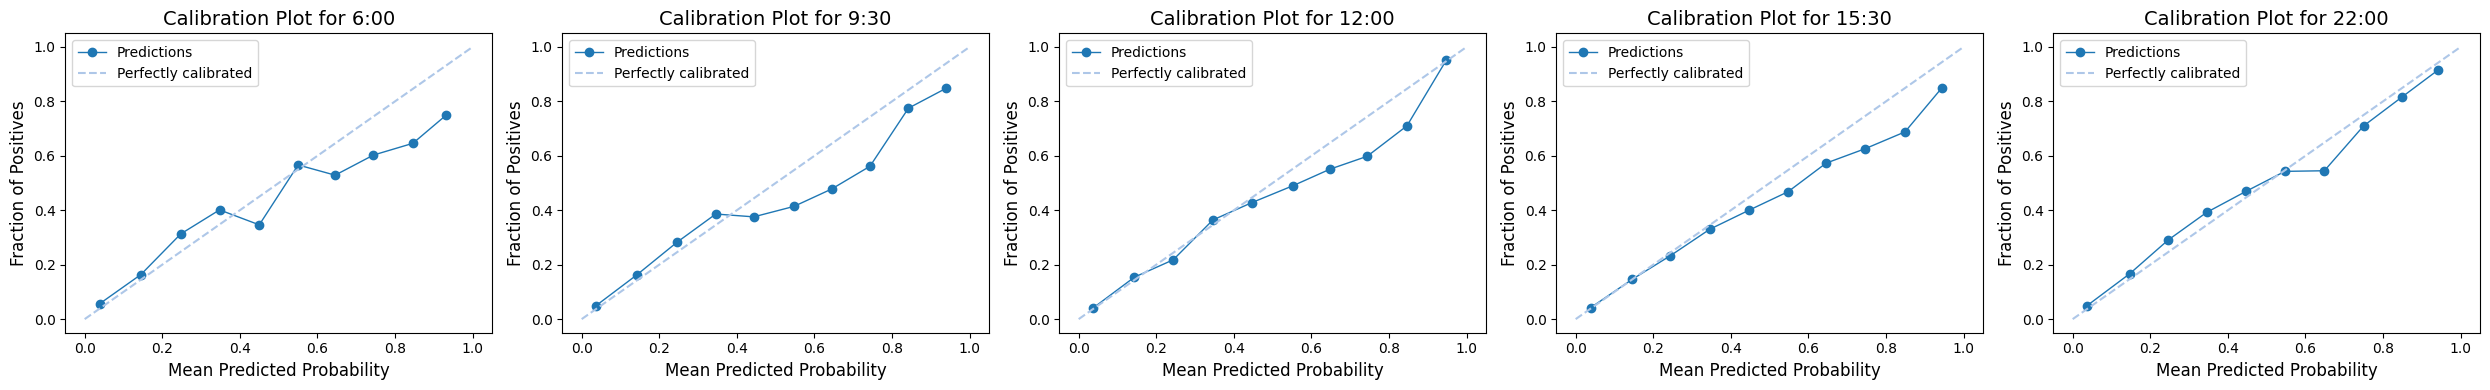

In [12]:
from prepare import prepare_for_inference


# Define the color scheme
primary_color = "#1f77b4"
secondary_color = "#aec7e8"


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve

num_plots = len(prediction_times)
fig_sizes = [(num_plots * 5, 4), (num_plots * 6, 4), (10, 14), (num_plots * 8, 6)]

def plot_calibration(prediction_times, strategy = 'uniform'):
    num_plots = len(prediction_times)
    fig, axs = plt.subplots(1, num_plots, figsize=(num_plots * 5, 4))

    for i, _prediction_time in enumerate(prediction_times):
        X_test, y_test, pipeline = prepare_for_inference(model_file_path = model_file_path, model_name = 'ed_admission', prediction_time = _prediction_time, data_path = visits_csv_path, single_snapshot_per_visit = False, model_only = False)

        prob_true, prob_pred = calibration_curve(y_test, pipeline.predict_proba(X_test)[:, 1], n_bins=10, strategy=strategy)

        ax = axs[i]

        hour, minutes = _prediction_time

        ax.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Predictions', color=primary_color)
        ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color=secondary_color)
        ax.set_title(f'Calibration Plot for {hour}:{minutes:02}', fontsize = 14)
        ax.set_xlabel('Mean Predicted Probability', fontsize = 12)
        ax.set_ylabel('Fraction of Positives', fontsize = 12)
        ax.legend()

    plt.tight_layout()

    calib_plot_path = media_file_path / 'calibration_plot'
    calib_plot_path = calib_plot_path.with_suffix('.png')
    
    plt.savefig(calib_plot_path)
    plt.show()

    
plot_calibration(prediction_times)

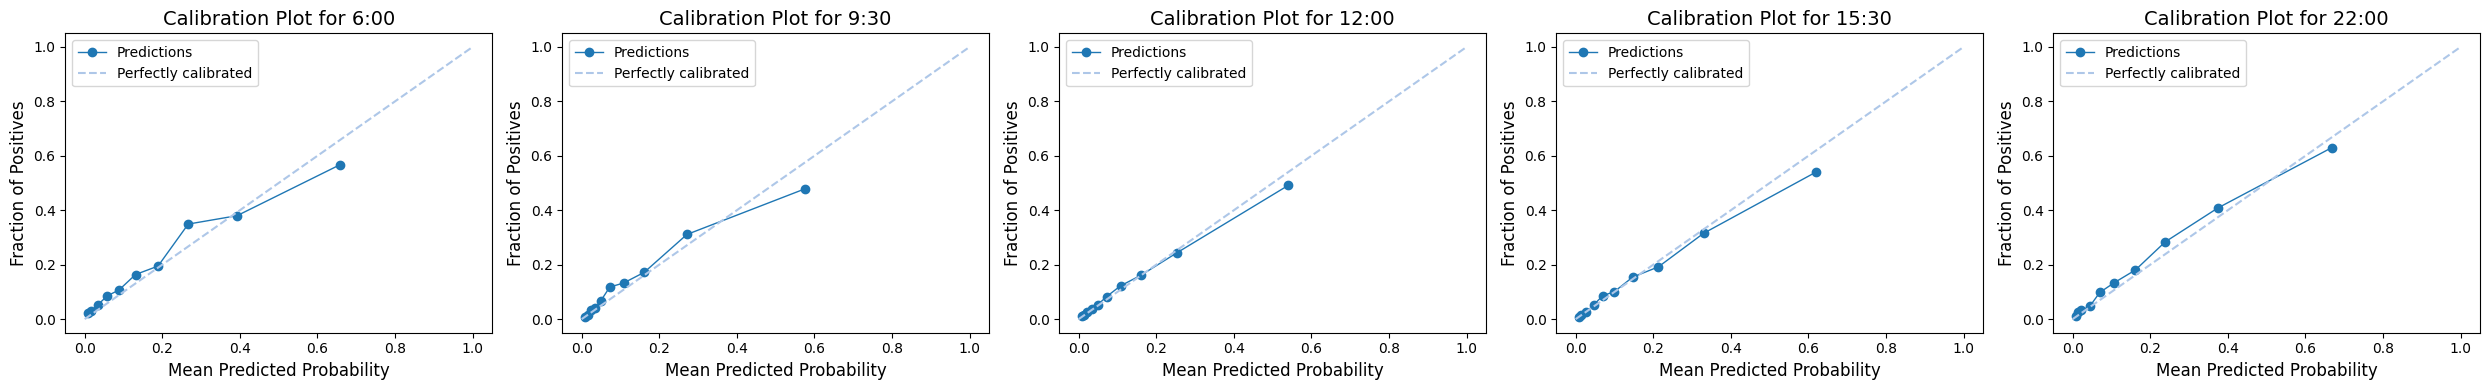

In [26]:

    
plot_calibration(prediction_times,  strategy = 'quantile')

### MADCAP plots

A MADCAP (Model Accuracy Diagnostic Calibration Plot) visually compares the predicted probabilities from a model with the actual outcomes (e.g., admissions or events) in a dataset. This plot helps to assess how well the model's predicted probabilities align with the observed values.

The blue line represents the cumulative predicted outcomes, which are derived by summing the predicted probabilities as we move through the test set, ordered by increasing probability.
The orange line represents the cumulative observed outcomes, calculated based on the actual labels in the dataset, averaged over the same sorted order of predicted probabilities.

If the model is perfectly calibrated, these two lines will closely follow each other, and the curves will bow to the bottom left. 

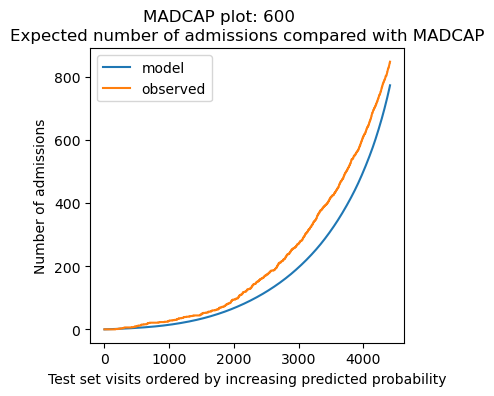

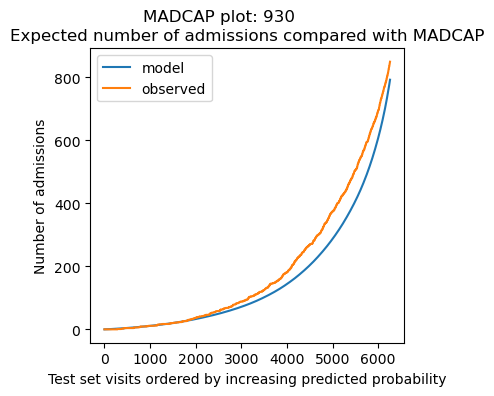

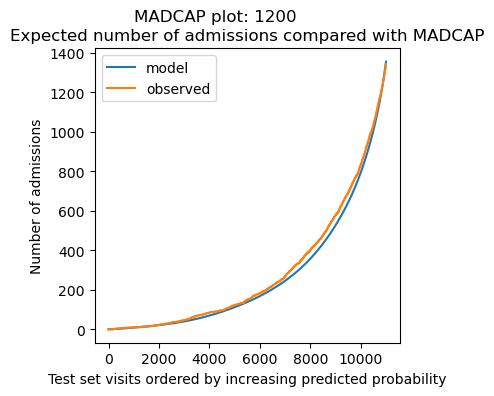

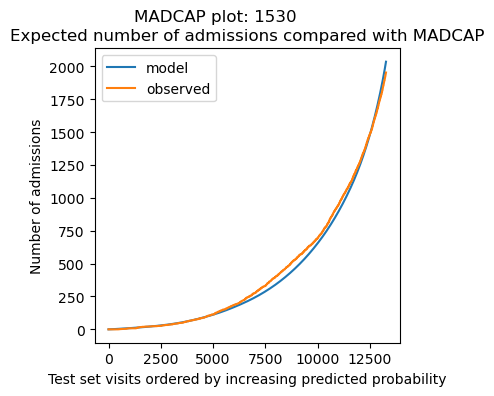

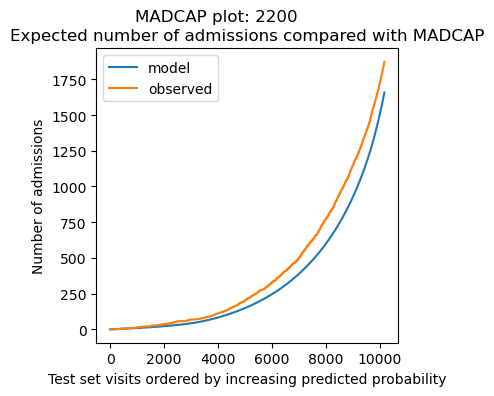

In [16]:
from viz.madcap_plot import plot_madcap, plot_madcap_by_group
from prepare import prepare_for_inference

exclude_from_training_data = [
    "visit_number",
    "snapshot_date",
    "prediction_time",
    "specialty",
    "consultation_sequence",
     "final_sequence"]


from prepare import get_snapshots_at_prediction_time
# Create a function to classify age groups
def classify_age_group(age_group):
    if age_group in ['0-17']:
        return 'children'
    elif age_group in ['18-24', '25-34', '35-44', '45-54', '55-64']:
        return 'adults'
    elif age_group in ['65-74', '75-102']:
        return 'over 65'
    else:
        return 'unknown' # Handle potential NaN or unexpected values

def classify_age(age_on_arrival):
    if age_on_arrival < 18:
        return 'children'
    elif age_on_arrival < 65:
        return 'adults'
    elif age_on_arrival >= 65:
        return '65 or over'
    else:
        return 'unknown' # Handle potential NaN or unexpected values
        
def generate_madcap_plots(prediction_times, grouping_var = None, grouping_var_name = None):
    
    for i, _prediction_time in enumerate(prediction_times):
        hour, minutes = _prediction_time
        dataset = f'{hour}{minutes:02}'
        
        X_test, y_test, pipeline = prepare_for_inference(
            model_file_path, 
            'ed_admission', 
            prediction_time = _prediction_time, 
            data_path = visits_csv_path, 
            single_snapshot_per_visit = False)


        predict_proba = pipeline.predict_proba(X_test)[:,1]

        if grouping_var:

            if 'age_group' in X_test.columns:

                group = X_test['age_group'].apply(classify_age_group)
            else:
                group = X_test['age_on_arrival'].apply(classify_age)
                
            plot_madcap_by_group(predict_proba, y_test , group, 
                                    dataset, grouping_var_name, media_file_path, plot_difference = False)
        
        else:
            plot_madcap(predict_proba, y_test, dataset, media_file_path, plot_difference = False)


generate_madcap_plots(prediction_times)

The plots above show the that 0600, 0930 and 2200 tend to underestimate the number of predictions. The 1200 and 1530 models are better, with the orange and blue lines almost on top of each other.

The plots below are separated into age groups. The models do best for adults, for which there are many more observations than for children, and do better for patients over 65 in the 1200 and 1530 models. 

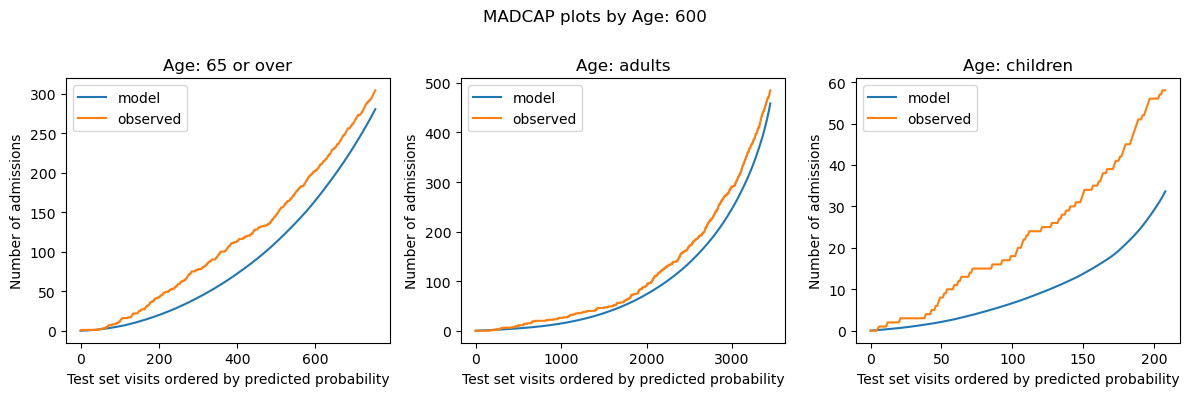

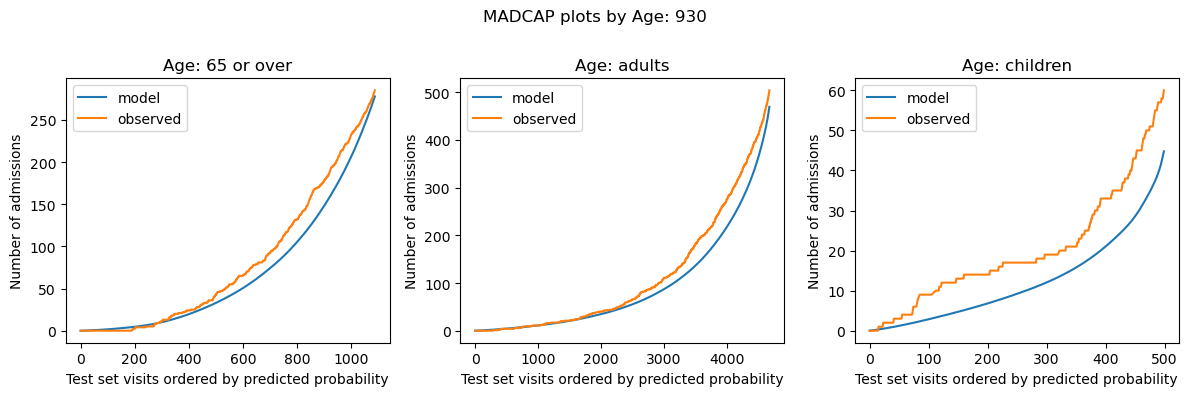

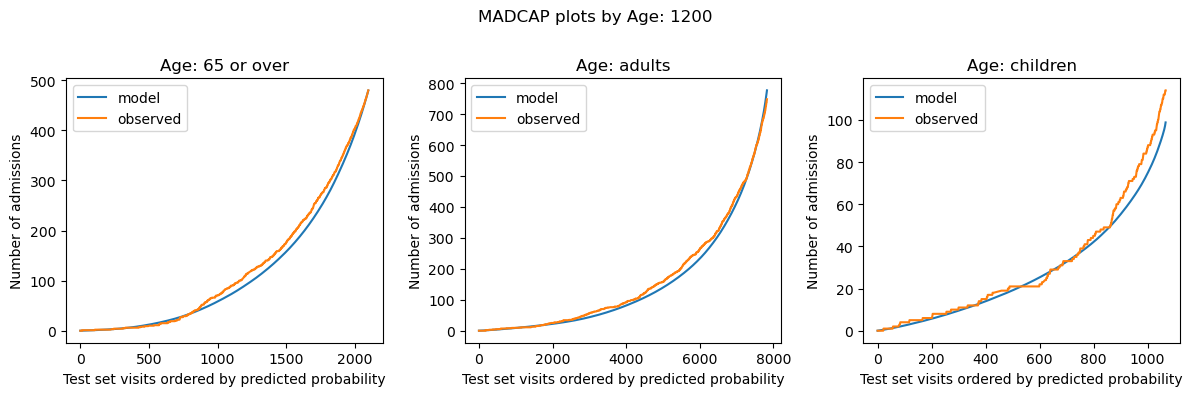

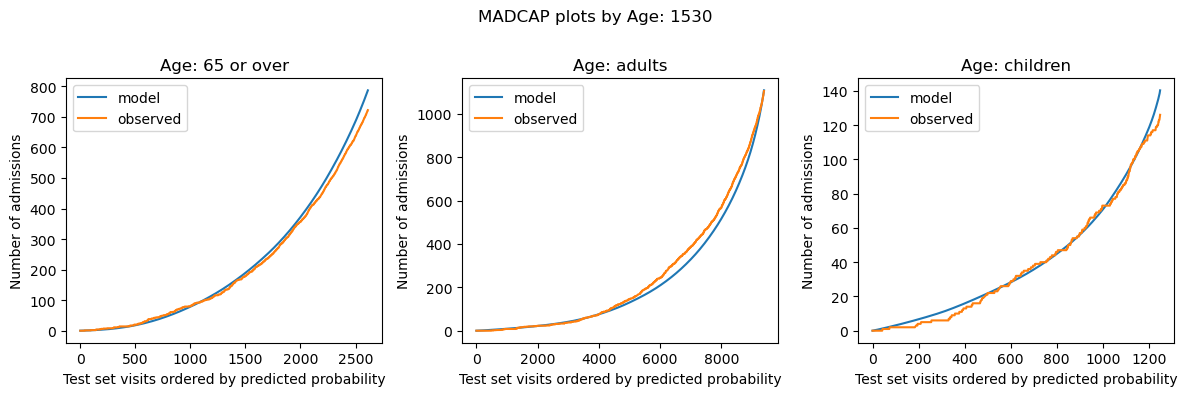

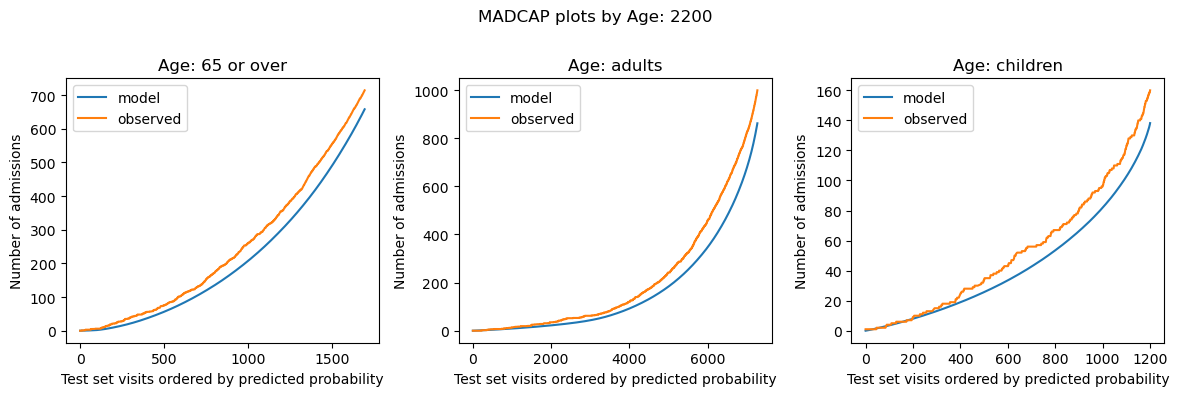

In [15]:

generate_madcap_plots(prediction_times, 'age_group', 'Age')

## Evaluation of the models predicting admission to ED (at aggregate level for each snapshot)

As the ultimate objective for these models is to predict bed numbers, not patient-level probability of admission, we need a way to evaluate the aggregate level. 

In order to evaluate the models' performance in aggregate, we first need to iterate through each snapshot date in the test set, creating a dictionary of all the predictions. The dictionary saves a probability distribution for each snapshot date, and the observed number of patients in the ED at that moment, who were actually admitted.




In [17]:
from prepare import prepare_for_inference, prepare_snapshots_dict
from load import get_model_name
from aggregate import get_prob_dist

prob_dist_dict_all = {}
# Process each time of day
for _prediction_time in prediction_times:

    print("\nProcessing :" + str(_prediction_time))
    
    model_name = get_model_name('ed_admission', _prediction_time)

    # prepare data 
    X_test, y_test, model = prepare_for_inference(model_file_path, 
        'ed_admission', 
        prediction_time = _prediction_time, 
        data_path = Path(data_file_path, visits_csv_path), 
        single_snapshot_per_visit = False)


    # select the snapshots to include in the probability distribution, 
    snapshots_dict = prepare_snapshots_dict(
        visits[(visits.training_validation_test == 'test') &
         (visits.prediction_time == _prediction_time)]
        )
    
    # get probability distribution for this time of day
    prob_dist_dict_all[model_name] = get_prob_dist(
            snapshots_dict, X_test, y_test, model
        )


Processing :(6, 0)
Calculating probability distributions for 182 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot dates
Processed 50 snapshot dates
Processed 60 snapshot dates
Processed 70 snapshot dates
Processed 80 snapshot dates
Processed 90 snapshot dates
Processed 100 snapshot dates
Processed 110 snapshot dates
Processed 120 snapshot dates
Processed 130 snapshot dates
Processed 140 snapshot dates
Processed 150 snapshot dates
Processed 160 snapshot dates
Processed 170 snapshot dates
Processed 180 snapshot dates
Processed 182 snapshot dates

Processing :(9, 30)
Calculating probability distributions for 182 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot dates
Processed 50 snapshot dates
Processed 60 snapshot dates
Processed 70 snapshot dates
Processed 80 snapshot dates
Processed

### QQ Plots

A  qq plot compares a predicted distribution to an observed distribution. In this case, the predicted distribution is the combined set of probability distributions (one for each snapshot date in the test set) at the given prediction time. The observed distribution is derived from the actual number of patients who were later admitted in each of those snapshot dates. 

If the predicted and observed distributions are similar, the qq plot should adhere closely to the y = x line in the plot. 


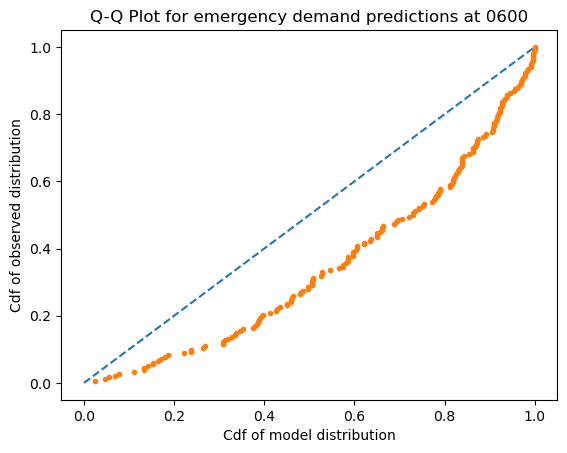

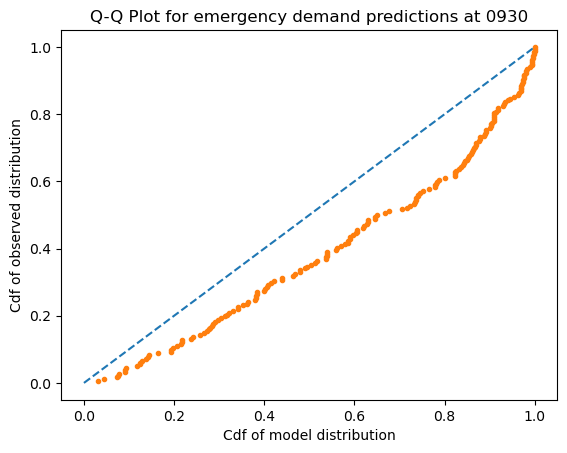

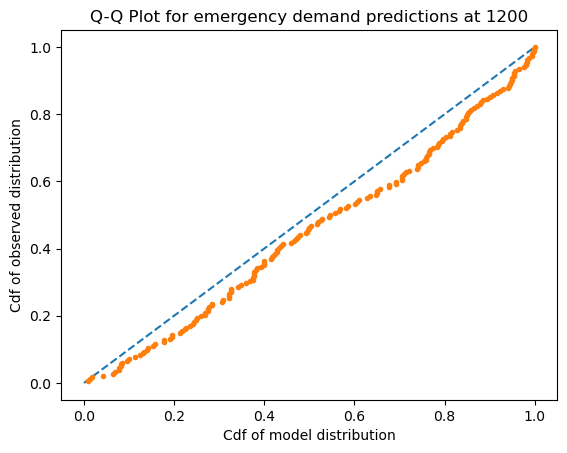

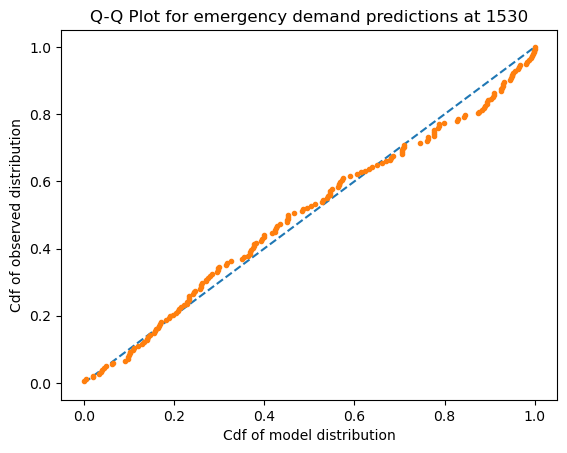

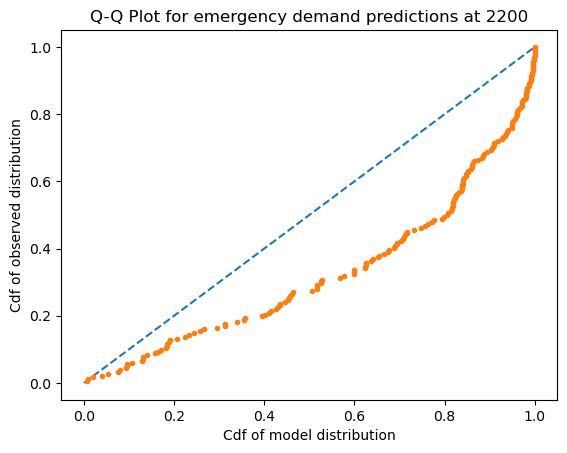

In [18]:
from viz.qq_plot import qq_plot

for _prediction_time in prediction_times:
    
    # retrieve name for the model based on the time of day
    hour_, min_ = _prediction_time
    min_ = f"{min_}0" if min_ % 60 == 0 else str(min_)
    model_name = 'ed_admission_' + f"{hour_:02}" + min_
    
    title_ = 'Q-Q Plot for emergency demand predictions at ' + f"{hour_:02}" + min_

    plt = qq_plot(snapshots_dict.keys(), prob_dist_dict_all[model_name], title_)
    
    # use model name in the path for saving the plot
    qq_plot_path = media_file_path / model_name 
    qq_plot_path = qq_plot_path.with_suffix('.png')
    
    plt.savefig(qq_plot_path)
        